# Common Plots for Metabolomics Datasets

In this notebook we will generate plots commonly used for exploring metabolomics datasets. 

In [2]:
# import necessary packages

import pandas as pd # for reading feature tables
import numpy as np # for doing math efficiently
import matplotlib.pyplot as plt # the main plotting library
import seaborn as sns # a secondary plotting library with many useful functions
from scipy.stats import ttest_ind, mannwhitneyu # for statietics
from sklearn.decomposition import PCA # sklearn is the go-to package for ML in python
from sklearn.preprocessing import StandardScaler # for scaling data before PCA

In [6]:
# demo data are at https://github.com/shuzhao-li/khipu/tree/main/testdata/
# Have a look via pd
ecoli = pd.read_table("../Datasets/ecoli_pos.tsv", sep="\t", index_col=0)
ecoli.head()

,mz,rtime,12C_Ecoli_20220321_004,12C_Ecoli_20220321_004_20220322095030,12C_Ecoli_20220321_004_20220322130235,13C_Ecoli_20220321_004,13C_Ecoli_20220321_004_20220322132355,13C_Ecoli_20220321_004_20220322101150
id_number,,,,,,,,
F1,61.9278,40.94,42543,0,0,43369,60144,57714
F2,95.9735,125.06,2079328,984349,1314348,1707804,1299125,1159692
F3,115.9802,11.42,3362695,3228128,4076328,3201740,3942341,3326312
F4,115.9860,5.83,2035714,1739145,1978764,1977817,2040421,1642861
F5,115.9860,27.96,182603,219669,248607,199092,185630,185255


In [7]:
# t-test of each row between 12C and 13C samples
# data are log2 transformed in this test to have more normal distribution; +1 to avoid log2(0)

def ttest(row):
    t,p = ttest_ind(np.log2(row[3:6]+1), np.log2(row[6:9]+1))
    return p

pvalues_featurelist = ecoli.apply(ttest, axis=1)
pvalues_featurelist = pvalues_featurelist.sort_values()
pvalues_featurelist.head(10)

id_number
F1039    4.028376e-13
F2201    3.386336e-11
F2955    4.471926e-11
F1417    1.217689e-10
F2675    2.118523e-10
F2784    2.630405e-10
F2663    8.330401e-10
F2930    1.497729e-09
F2874    2.037131e-09
F3182    2.161996e-09
dtype: float64

In [8]:
most_significant = pvalues_featurelist.index[0]
print(most_significant)

ecoli2 = pd.read_table("../Datasets/ecoli_pos.tsv", sep="\t")
ecoli2.head()

ft_lookup = {}
for x in ecoli2.to_dict(orient='records'):
    ft_lookup[x['id_number']] = x

print(ft_lookup)
all_samples = [x for x in ft_lookup[most_significant].keys() if "Ecoli" in x]
print(all_samples)
C12_samples = [x for x in all_samples if "12C" in x]
C13_samples = [x for x in all_samples if "13C" in x]


F1039
{'F1': {'id_number': 'F1', 'mz': 61.9278, 'rtime': 40.94, '12C_Ecoli_20220321_004': 42543, '12C_Ecoli_20220321_004_20220322095030': 0, '12C_Ecoli_20220321_004_20220322130235': 0, '13C_Ecoli_20220321_004': 43369, '13C_Ecoli_20220321_004_20220322132355': 60144, '13C_Ecoli_20220321_004_20220322101150': 57714}, 'F2': {'id_number': 'F2', 'mz': 95.9735, 'rtime': 125.06, '12C_Ecoli_20220321_004': 2079328, '12C_Ecoli_20220321_004_20220322095030': 984349, '12C_Ecoli_20220321_004_20220322130235': 1314348, '13C_Ecoli_20220321_004': 1707804, '13C_Ecoli_20220321_004_20220322132355': 1299125, '13C_Ecoli_20220321_004_20220322101150': 1159692}, 'F3': {'id_number': 'F3', 'mz': 115.9802, 'rtime': 11.42, '12C_Ecoli_20220321_004': 3362695, '12C_Ecoli_20220321_004_20220322095030': 3228128, '12C_Ecoli_20220321_004_20220322130235': 4076328, '13C_Ecoli_20220321_004': 3201740, '13C_Ecoli_20220321_004_20220322132355': 3942341, '13C_Ecoli_20220321_004_20220322101150': 3326312}, 'F4': {'id_number': 'F4', 'm

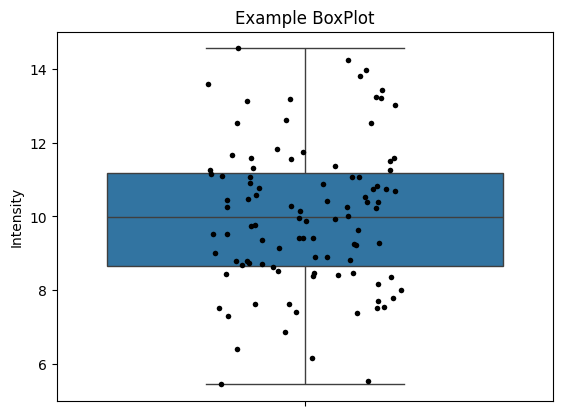

In [9]:
# for plotting, seaborn is an excellent choice as it natively can produce many of the plots a metabolomics data scientist would like to make.
# seaborn is actually just a wrapper around matplotlib, so everything you know about matplotlib applies to seaborn too (with some tweaking)

import seaborn as sns
import numpy as np

# Generate some data
data = np.random.normal(10, 2, 100)

# Create the box plot
sns.boxplot(data=data, showfliers=False)

# Add scatter points
sns.stripplot(data=data, color="black", size=4, jitter=0.2)

# here we can do some matplotlib fun and add titles and axes labels
plt.title("Example BoxPlot")
plt.ylabel("Intensity")

plt.show()

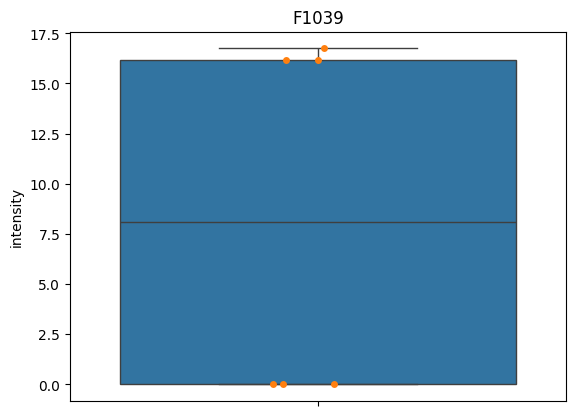

In [10]:
#lets look at the 

values = [np.log2(ft_lookup[most_significant][x] + 1) for x in all_samples]
sns.boxplot(values)
sns.stripplot(values)
plt.title(most_significant)
plt.ylabel("intensity")
plt.show()

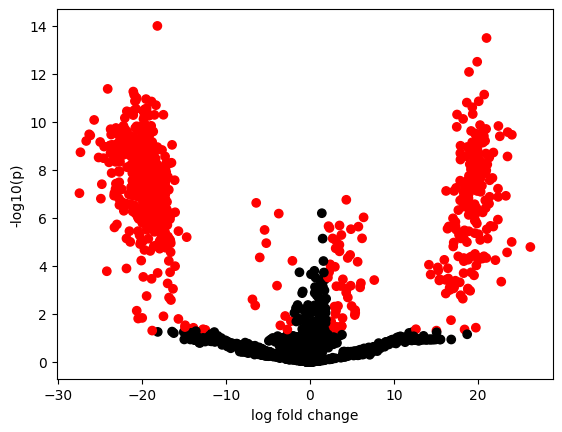

In [11]:
# volcano plot

ALPHA = 0.05 # significance threshold
FC_CUTOFF = 2 # fold change cutoff

fold_changes = []
p_values = []
colors = []
for ft_id, ft in ft_lookup.items():
    C12_values = np.array([ft[x] for x in C12_samples])
    C13_values = np.array([ft[x] for x in C13_samples])
    fc = np.mean(np.log2(C12_values+1)) - np.mean(np.log2(C13_values+1))
    t, p_val = ttest_ind(np.log2(C12_values+1), np.log2(C13_values+1))
    fold_changes.append(fc)
    p_values.append(-np.log10(p_val))
    if p_val < ALPHA and abs(fc) > FC_CUTOFF:
        colors.append('r')
    else:
        colors.append('k')
plt.ylabel("-log10(p)")
plt.xlabel("log fold change")
plt.scatter(fold_changes, p_values, c=colors)
plt.show()

Text(0.5, 0.98, 'clustermap log2 transformed')

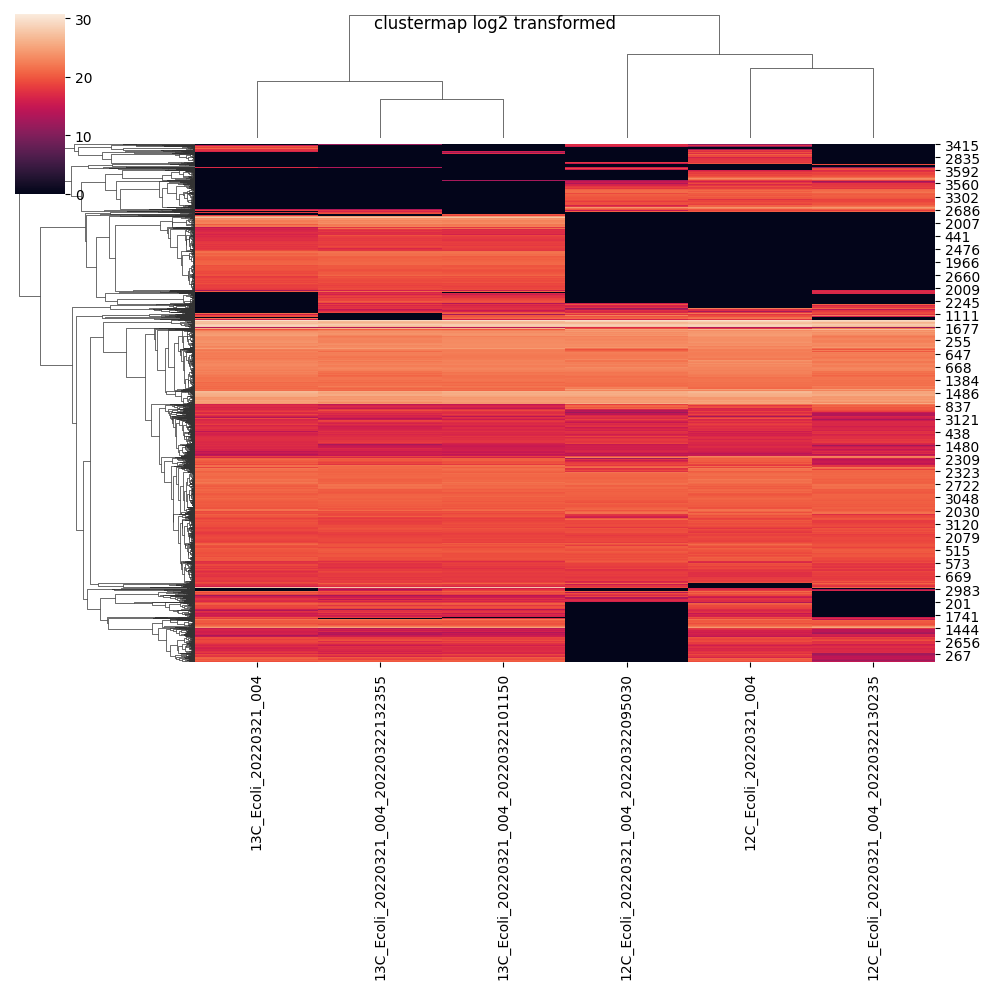

In [12]:
# now lets make a clustermap. A clustermap is like a heatmap, but the samples are organized based on some linkage between features.
# with the default parameters we get something like this:

sns.clustermap(np.log2(ecoli2[all_samples]+1))
plt.suptitle("clustermap log2 transformed")

Text(0.5, 0.98, 'clustermap log2 transformed')

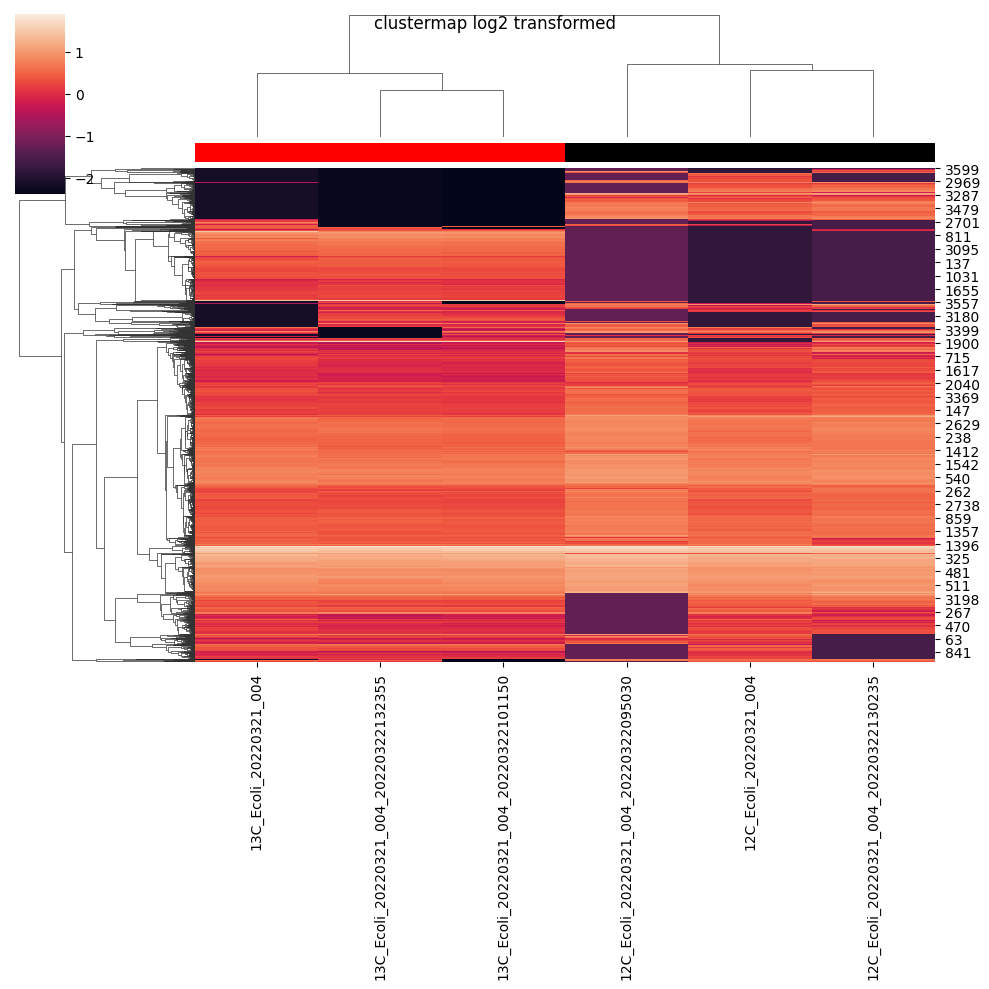

In [13]:
# in many cases, the z-score is a more appropriate value on which to do the linkage, fortunately, seaborn can do that for you: 


# we can also add column colors to show the grouping based on a variable of interest, in this case, the labelling status of the samples

col_colors = ['k' if x in C12_samples else 'r' for x in all_samples]
sns.clustermap(np.log2(ecoli2[all_samples]+1), z_score=1, col_colors=col_colors)
plt.suptitle("clustermap log2 transformed")

# we can see that samples clearly cluster on the basis of labelling status which is expected

In [20]:
# PCA plots

S = StandardScaler()
pca = PCA(n_components=2)
ft = np.array(ecoli2[ecoli2.columns[11:]])
ft2 = S.fit_transform(ecoli2[ecoli2.columns[11:]])

ValueError: at least one array or dtype is required